In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [2]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [65]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()


#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [66]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()

field = 'total'

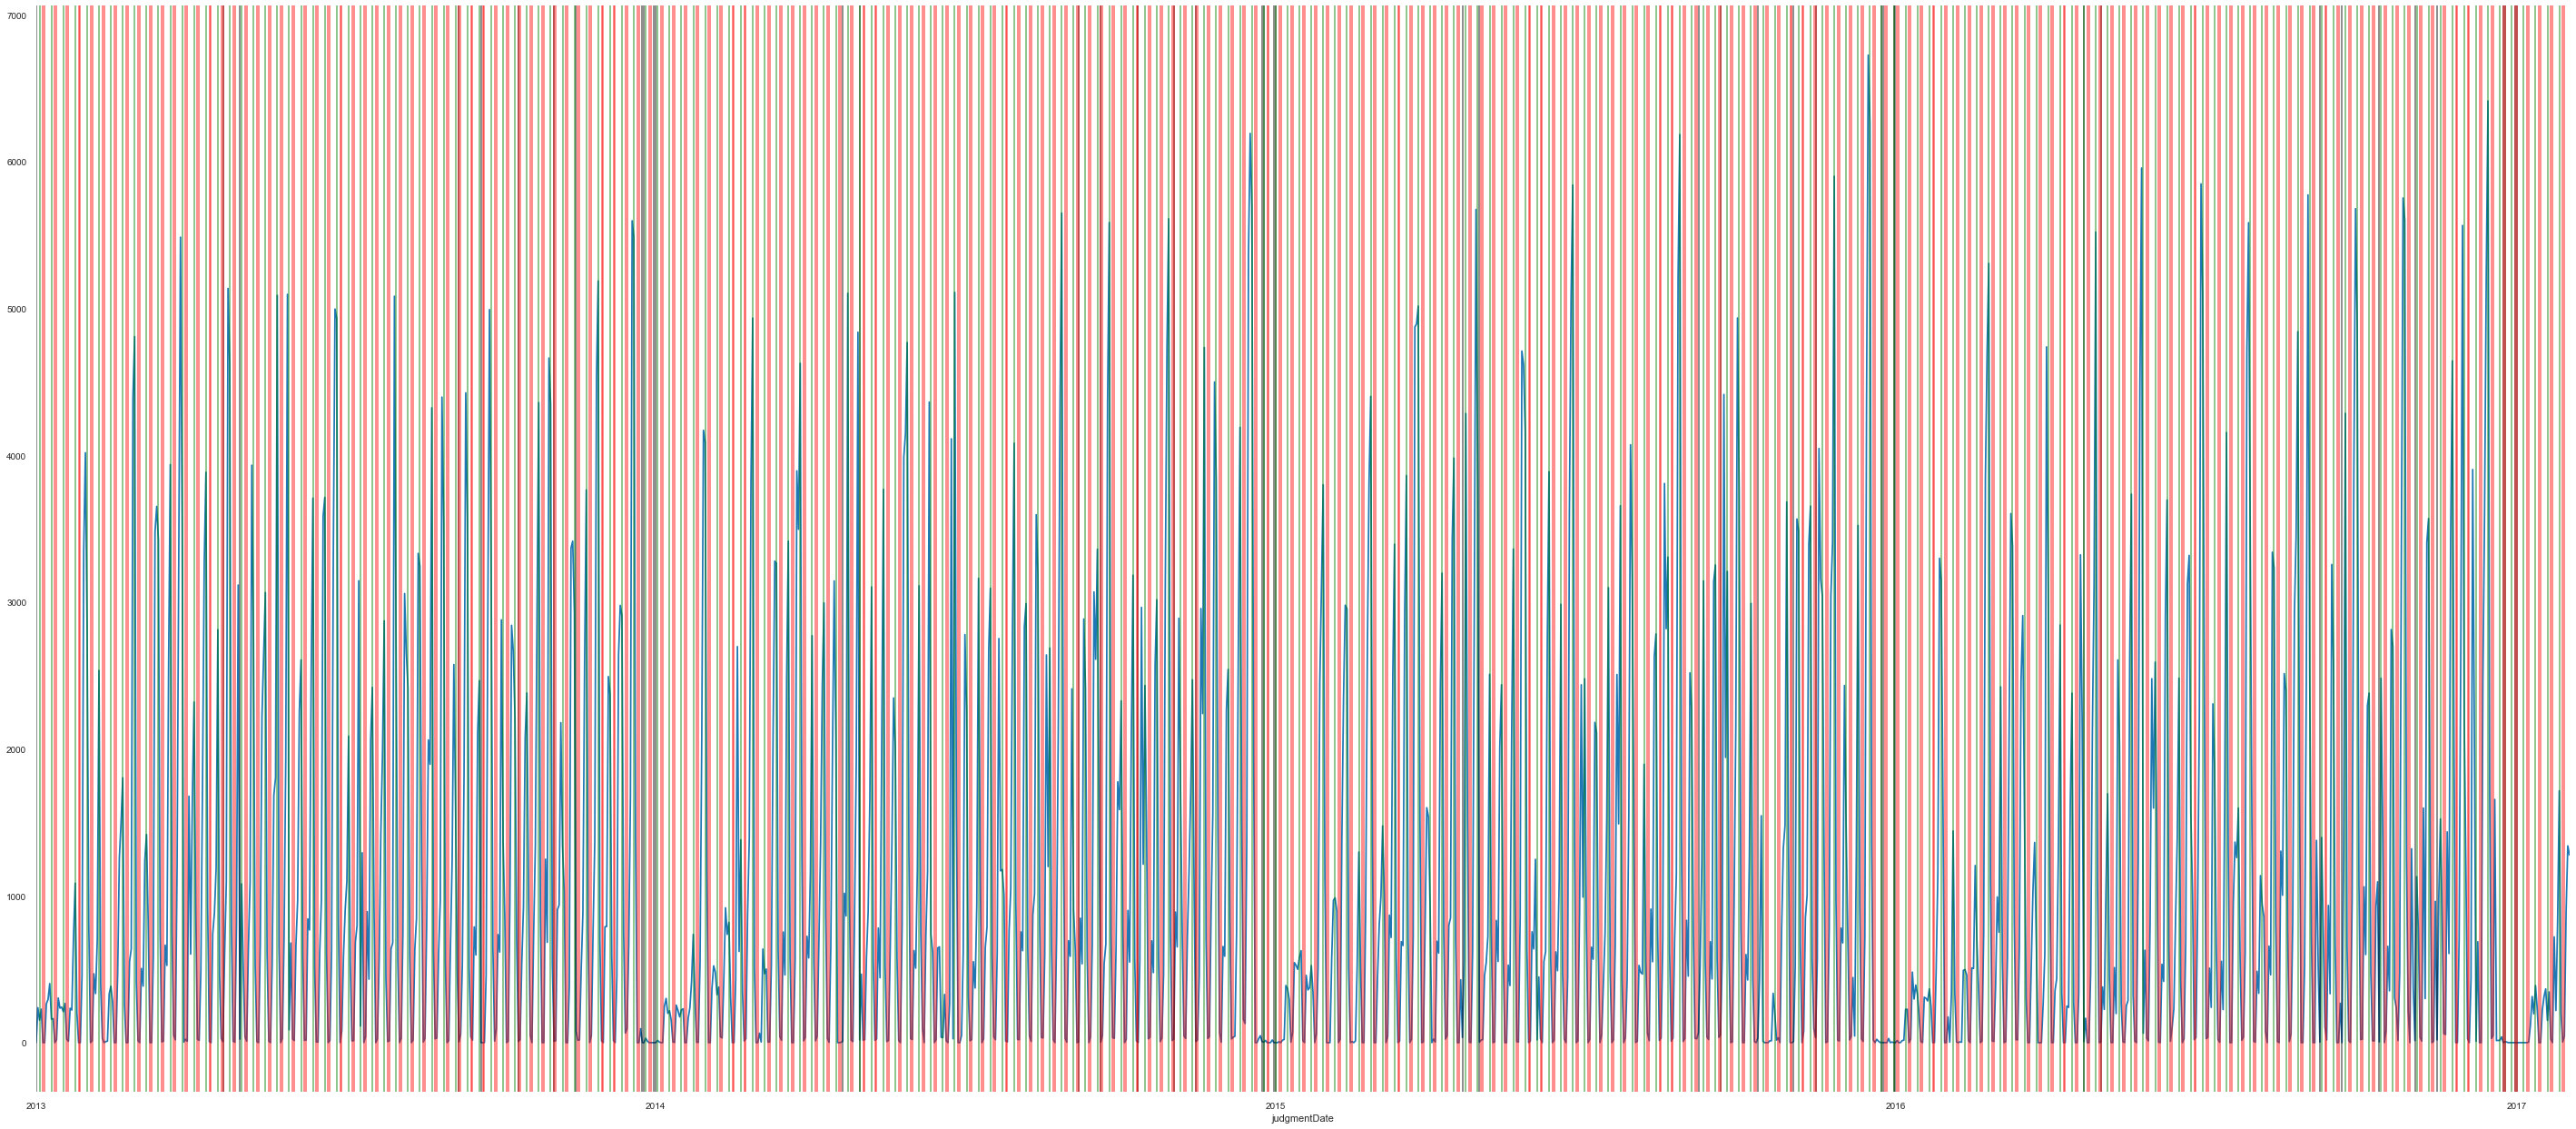

In [67]:
#df_count_day_typeGRP['total']['2017-01-01':].plot(figsize=(18,8))

ax = df[field]['2013-01-01':'2017-02-01'].plot(figsize=(50,22))

for dia in df.query('Feriado==0').index:    
    ax.axvline(x=dia,color='black',alpha=0.5)
    
for dia in df.query('weekType==0').index:    
    ax.axvline(x=dia,color='red',alpha=0.5)
    
for dia in df.query('weekDay==3').index:    
    ax.axvline(x=dia,color='green',alpha=0.5)



In [97]:
field = 'total'# dfUniqueTypes[1] 
summ = auto_arima(dfMonth['2012-01-11':][field],seasonal=True,m=12)

In [98]:
arima_order = summ.order
arima_seasonal_order = summ.seasonal_order
titleTest = "Arima({}) - ({})".format(arima_order,arima_seasonal_order)

In [99]:
test_size = (len(dfMonth['2012-01-11':]) - int((30 * len(dfMonth['2012-01-11':]))/100))
train = dfMonth['2012-01-11':].iloc[:test_size]
test = dfMonth['2012-01-11':].iloc[test_size:]  

#train = dfMonth['2012-01-11':][:49]
#test = dfMonth['2012-01-11':][49:]

print(train[field].count(),test[field].count())

50 21


In [100]:
model = SARIMAX(train[field],order=arima_order,seasonal_order=arima_seasonal_order)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    total   No. Observations:                   50
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -382.159
Date:                  Sat, 09 May 2020   AIC                            766.318
Time:                          13:08:25   BIC                            767.956
Sample:                      02-01-2012   HQIC                           766.901
                           - 03-01-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.982e+07   3.79e+06      7.876      0.000    2.24e+07    3.72e+07
===================================================================================
Ljung-Box (Q):                       35.51   Jarque-Bera (JB):                23.74
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               7.46   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(titleTest + "  - predictions" )

In [102]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[field][i]}")

predicted=39858.0    , expected=29430
predicted=33874.0    , expected=32323
predicted=36951.0    , expected=43079
predicted=36128.0    , expected=37558
predicted=38498.0    , expected=42889
predicted=38595.0    , expected=38185
predicted=21546.0    , expected=38016
predicted=44913.0    , expected=37940
predicted=31094.0    , expected=31787
predicted=13437.0    , expected=8625
predicted=23140.0    , expected=27182
predicted=35464.0    , expected=44352
predicted=39858.0    , expected=32122
predicted=33874.0    , expected=36348
predicted=36951.0    , expected=33469
predicted=36128.0    , expected=33513
predicted=38498.0    , expected=41151
predicted=38595.0    , expected=32798
predicted=21546.0    , expected=37399
predicted=44913.0    , expected=36963
predicted=31094.0    , expected=28936


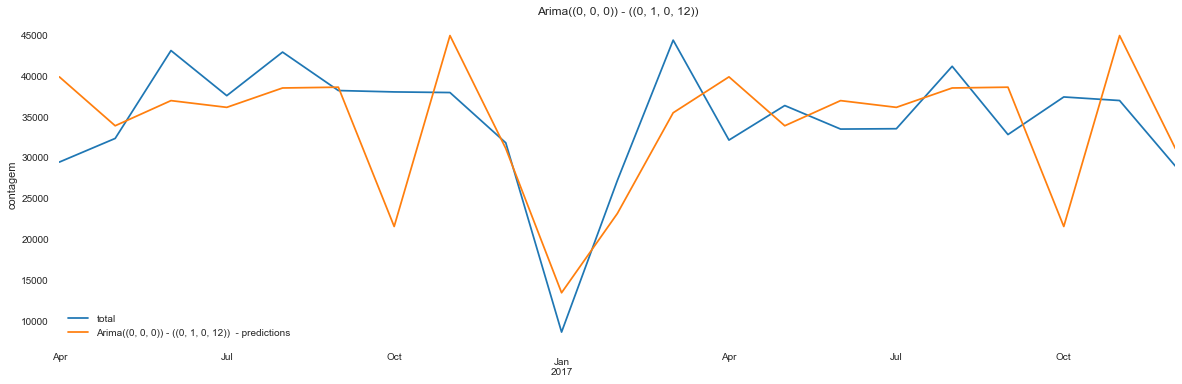

In [103]:
title = titleTest
ylabel='contagem'
xlabel=''

ax = test[field].plot(legend=True,figsize=(20,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [104]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test[field], predictions)
print(titleTest + f' MSE Error: {error:11.10}')

Arima((0, 0, 0)) - ((0, 1, 0, 12)) MSE Error: 50180866.29


In [105]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test[field], predictions)
print(titleTest + f' SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}---{error}')

Arima((0, 0, 0)) - ((0, 1, 0, 12)) SARIMA(0,1,3)(1,0,1,12) RMSE Error: 7083.845445---7083.845444792983


In [106]:
model = SARIMAX(dfMonth['2012-01-11':][field],order=arima_order,seasonal_order=arima_seasonal_order)
results = model.fit()
fcast = results.predict(len(dfMonth['2012-01-11':]),len(dfMonth['2012-01-11':])+11,typ='levels').rename('SARIMA '+ titleTest + ' Forecast')

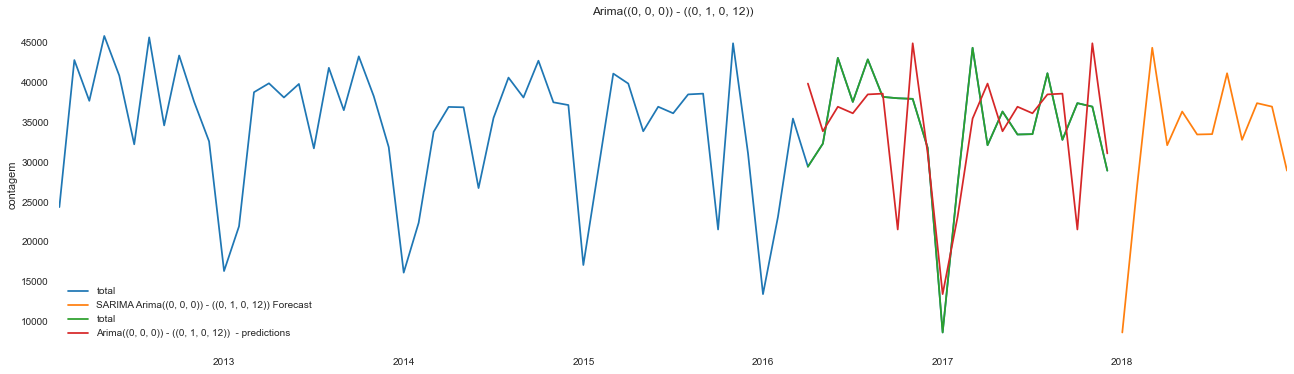

In [107]:
ax = dfMonth['2012-01-11':][field].plot(legend=True,figsize=(22,6),title=title)
fcast.plot(legend=True)
test[field].plot(legend=True)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);